In [1]:
import os

nb_name = "nb20230626_190400_ACh_cueonset_response_change.ipynb" #TODO change this

basename, ext = os.path.splitext(nb_name)
input_path = os.path.join(os.getcwd(), nb_name)

!jupyter nbconvert "{input_path}" --to="python" --output="{basename}"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230626_190400_ACh_cueonset_response_change.ipynb to python
[NbConvertApp] Writing 22176 bytes to d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230626_190400_ACh_cueonset_response_change.py


based on notebooks\noncanonical\nb20230622_215600_ACh_cueonset_2_outcomes.ipynb


- Calculate the CC and linregress slope for ACh dip, rebound, and DA peak against trial_nb
- We should be able to find sessions in which ACh rebound stays while ACh dip goes away.
- By detecting slow trough in data, we could also find sessions with recovery
- Should we also analyse data around spount? Movement encoding may be more stable.
- We can use `lme4` for ACh dip etc.


- scatter plots for `trial_nb` against dip size etc 
- dip size
    - selected_data = xr_photometry['hold_for_water_zscored_df_over_f'].sel(trial_nb=k, event_time=slice(150, 300))
- rebound size
    - selected_data = xr_photometry['hold_for_water_zscored_df_over_f'].sel(trial_nb=k, event_time=slice(350, 700))


\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22\TT002-2023-06-22-111549\processed

- lots of abortions


In [46]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import re
from matplotlib import pyplot as plt
import itertools
import seaborn as sns


from trialexp.process.pyphotometry.utils import *
from trialexp.process.pycontrol import event_filters
from trialexp.process.pycontrol.event_filters import extract_event_time
from trialexp.process.pyphotometry.utils import measure_ACh_dip_rebound, measure_DA_peak



# by_sessions_dir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions'
# task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')
# task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')
# data_dir = os.path.join(task_dir, 'TT002-2023-06-05-154932', 'processed')

# xr_photometry = xr.open_dataset(os.path.join(data_dir, 'xr_photometry.nc'))
# xr_session = xr.open_dataset(os.path.join(data_dir, 'xr_session.nc'))
# df_pycontrol = pd.read_pickle(os.path.join(data_dir, 'df_pycontrol.pkl'))
# df_events = pd.read_pickle(os.path.join(data_dir, 'df_events_cond.pkl'))


In [47]:


by_sessions_dir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions'
task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')

items = os.listdir(task_dir)
data_dirs = [os.path.join(task_dir, item, 'processed') for item in items if os.path.isdir(os.path.join(task_dir, item))]
session_ids = [item for item in items if os.path.isdir(os.path.join(task_dir, item))]
subject_ids = [re.match(r"(\w+)-", ssid).group(1) for ssid in session_ids]


In [ ]:
## Test data

# data_dirs = [os.path.join(
#     task_dir, 'TT002-2023-06-05-154932', 'processed')]
# session_ids = [item for item in items if os.path.isdir(os.path.join(task_dir, item))]
# subject_ids = ['TT002']


# Compute ACh
3 m 47 s for the folder 'reaching_go_spout_bar_nov22' and the 5 mice

In [48]:
subject_ids_ACh = ['TT001','TT002','TT005','RE606', 'RE607']

ind_ACh = [ind for ind, sbj in enumerate(subject_ids) if sbj in subject_ids_ACh]


In [49]:

data = []

for dd, ss, sj in zip([data_dirs[i] for i in ind_ACh], [session_ids[i] for i in ind_ACh], [subject_ids[i] for i in ind_ACh]):

    df_trials, lin_regress_dip, lin_regress_rebound, lin_regress_dip_rebound, \
        is_success, msg = measure_ACh_dip_rebound(dd)
    n_trials = np.nan
    if isinstance(df_trials, pd.DataFrame):
        n_trials = df_trials.shape[0]
    row_data_list = [ss] + [sj] + [df_trials] + [n_trials] + list(lin_regress_dip.values()) + list(
        lin_regress_rebound.values()) + list(lin_regress_dip_rebound.values()) + [is_success] + [msg] + [dd]
    data.append(row_data_list)

df_ACh_cue_onset = pd.DataFrame(data)

df_ACh_cue_onset.columns = ['session_id', 'subject_id', 'df_trials', 'n_trials',
              'trial_nb_dip_slope', 'trial_nb_dip_intercept', 'trial_nb_dip_r_value', 'trial_nb_dip_p_value', 'trial_nb_dip_std_er',
              'trial_nb_rebound_slope', 'trial_nb_rebound_intercept', 'trial_nb_rebound_r_value', 'trial_nb_rebound_p_value', 'trial_nb_rebound_std_er',
              'dip_rebound_slope', 'dip_rebound_intercept', 'dip_rebound_r_value', 'dip_rebound_p_value', 'dip_rebound_std_er',
              'is_success', 'msg', 'data_dir']


In [50]:

mask = (df_ACh_cue_onset['n_trials'].notnull()) & (df_ACh_cue_onset['n_trials'] > 100) & df_ACh_cue_onset['is_success']
df_ACh_cue_onset_100 = df_ACh_cue_onset.loc[mask]

df_ACh_cue_onset_100['n_trials']

0     107.0
1     201.0
2     209.0
3     142.0
4     371.0
      ...  
88    444.0
89    333.0
90    255.0
92    189.0
93    181.0
Name: n_trials, Length: 77, dtype: float64

# Compute DA


In [55]:
subject_ids_DA = ['kms058','kms062','kms063','kms064', 'JC317L']

ind_DA = [ind for ind, sbj in enumerate(subject_ids) if sbj in subject_ids_DA]


In [56]:
data = []

for dd, ss, sj in zip([data_dirs[i] for i in ind_DA], [session_ids[i] for i in ind_DA], [subject_ids[i] for i in ind_DA]):

    df_trials, lin_regress_pk, \
        is_success, msg = measure_DA_peak(dd)
    n_trials = np.nan
    if isinstance(df_trials, pd.DataFrame):
        n_trials = df_trials.shape[0]
    row_data_list = [ss] + [sj] + [df_trials] + [n_trials] + list(lin_regress_pk.values()) + [is_success] + [msg] + [dd]
    data.append(row_data_list)

df_DA_cue_onset = pd.DataFrame(data)

df_DA_cue_onset.columns = ['session_id', 'subject_id', 'df_trials', 'n_trials',
                            'trial_nb_pk_slope', 'trial_nb_pk_intercept', 'trial_nb_pk_r_value', 'trial_nb_pk_p_value', 'trial_nb_pk_std_er',
                            'is_success', 'msg', 'data_dir']


#'TT002-2023-06-05-154932',

print(df_ACh_cue_onset.trial_nb_dip_r_value)
print(df_ACh_cue_onset.trial_nb_rebound_r_value)
print(df_ACh_cue_onset.dip_rebound_r_value)

0    0.525112
Name: trial_nb_dip_r_value, dtype: float64
0   -0.29187
Name: trial_nb_rebound_r_value, dtype: float64
0    0.001605
Name: dip_rebound_r_value, dtype: float64


In [57]:

mask = (df_DA_cue_onset['n_trials'].notnull()) & (
    df_DA_cue_onset['n_trials'] > 100) & df_DA_cue_onset['is_success']
df_DA_cue_onset_100 = df_DA_cue_onset.loc[mask]

df_DA_cue_onset_100['n_trials']


10     207.0
12     199.0
13     212.0
15     176.0
16     155.0
       ...  
130    163.0
131    180.0
132    210.0
133    131.0
135    115.0
Name: n_trials, Length: 78, dtype: float64

## Plotting style

In [74]:


# Define your list of markers
markers = itertools.cycle(
    ('o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'))

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams["legend.frameon"] = False
plt.rcParams['xtick.bottom']=True
plt.rcParams['ytick.left']=True
plt.rcParams['font.family']= 'Arial'

plt.rcParams['axes.labelsize'] = 12


# ACh

Text(-0.8, -0.5, 'Decreasing in size')

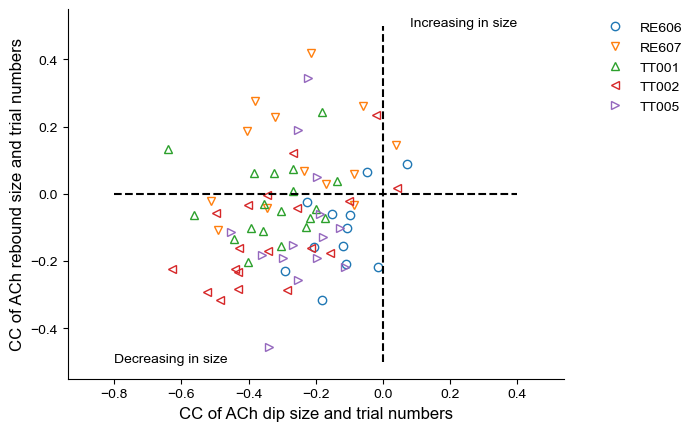

In [75]:

fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for sbj in subject_ids_:
    x = - 1 * df_ACh_cue_onset_100['trial_nb_dip_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj]
    y = df_ACh_cue_onset_100['trial_nb_rebound_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj]

    ax.plot(x, y, marker=next(markers), linestyle='None', fillstyle='none', label = sbj)

plt.axis('equal')

# ax.set_xlim()
# ax.set_ylim()

ax.plot([-0.8, 0.4], [0, 0], '--k')
ax.plot([0, 0], [-0.5, 0.5],  '--k')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CC of ACh dip size and trial numbers')
plt.ylabel('CC of ACh rebound size and trial numbers')

# Negative CCs mean the absolute size of dip and rebound is reducing

ax.text(0.4, 0.5, 'Increasing in size', ha = 'right')
ax.text(-0.8, -0.5, 'Decreasing in size', ha = 'left')


In [62]:
np.count_nonzero((df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < 0.1) &
                 (df_ACh_cue_onset_100['trial_nb_rebound_r_value'] > 0.1))


12

In [44]:
# find sessions with CC for dip > 0.1, CC for rebound > 0.1

ss_dp = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < -0.2) & 
                          (df_ACh_cue_onset_100['trial_nb_rebound_r_value'] > 0.2) , 'session_id']

ss_dp



14    RE607-2023-05-24-103758
16    RE607-2023-05-26-121015
17    RE607-2023-05-28-163935
82    TT005-2023-05-29-131014
Name: session_id, dtype: object

In [52]:
ss_rdp = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_rebound_r_value'] > 0.2), 'session_id']

ss_rdp


14    RE607-2023-05-24-103758
15    RE607-2023-05-25-104806
16    RE607-2023-05-26-121015
17    RE607-2023-05-28-163935
31    TT001-2023-05-29-135910
58    TT002-2023-05-25-124141
82    TT005-2023-05-29-131014
Name: session_id, dtype: object

In [43]:
ss_dd = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < -0.2) &
                                 (df_ACh_cue_onset_100['trial_nb_rebound_r_value'] < -0.2), 'session_id']
ss_dd


4     RE606-2023-05-31-115641
35    TT001-2023-06-02-163605
59    TT002-2023-05-26-154844
60    TT002-2023-05-29-133612
61    TT002-2023-05-30-142840
66    TT002-2023-06-05-154932
67    TT002-2023-06-06-152000
68    TT002-2023-06-07-145802
71    TT002-2023-06-19-141706
79    TT005-2023-05-24-163108
88    TT005-2023-06-05-145911
Name: session_id, dtype: object

Text(0.5, 1.0, 'Average per animal')

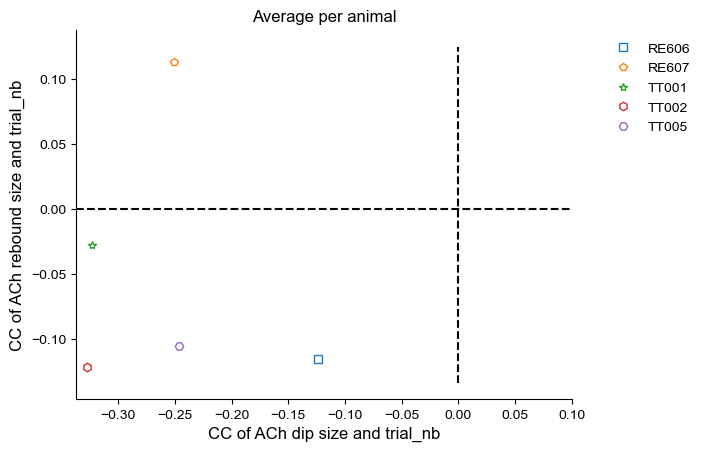

In [76]:
fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for sbj in subject_ids_:
    x = -1 * np.mean(df_ACh_cue_onset_100['trial_nb_dip_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj])
    y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj])

    ax.plot(x, y, marker=next(markers), linestyle='None',
            fillstyle='none', label=sbj)


XLIM = ax.get_xlim()
ax.set_xlim([XLIM[0], 0.1])
XLIM = ax.get_xlim()

YLIM = ax.get_ylim()

ax.plot(XLIM, [0, 0], '--k')
ax.plot([0, 0], YLIM,  '--k')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CC of ACh dip size and trial_nb')
plt.ylabel('CC of ACh rebound size and trial_nb')
plt.title('Average per animal')


In [66]:
subject_ids_


{'RE606', 'RE607', 'TT001', 'TT002', 'TT005'}

Text(37.222222222222214, 0.5, 'CC of ACh dip size and trial number')

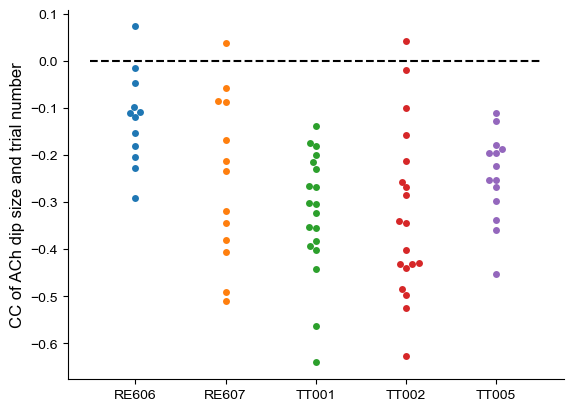

In [77]:
fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for i, sbj in enumerate(subject_ids_):
    # minus means moving the other ways
    y = (df_ACh_cue_onset_100['trial_nb_dip_r_value']
         [df_ACh_cue_onset_100['subject_id'] == sbj]) * -1
    # y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_ACh_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)
plt.ylabel('CC of ACh dip size and trial number')


Text(37.222222222222214, 0.5, 'CC of ACh rebound size and trial number')

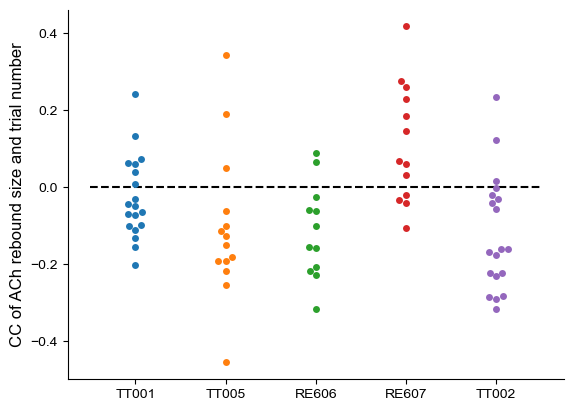

In [79]:
fig, ax = plt.subplots()

subject_ids_ = set(df_ACh_cue_onset_100['subject_id'])

for i, sbj in enumerate(subject_ids_):
    # minus means moving the other ways
    y = (df_ACh_cue_onset_100['trial_nb_rebound_r_value']
         [df_ACh_cue_onset_100['subject_id'] == sbj])
    # y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_ACh_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)
plt.ylabel('CC of ACh rebound size and trial number')


Text(37.222222222222214, 0.5, 'CC of DA peak size and trial number')

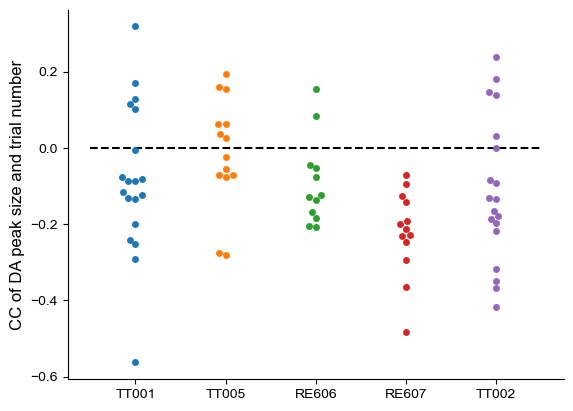

In [80]:

fig, ax = plt.subplots()

subject_ids_ = set(df_ACh_cue_onset_100['subject_id'])

for i, sbj in enumerate(subject_ids_):
    y = (df_ACh_cue_onset_100['dip_rebound_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj]) * -1 # minus means moving the other ways
    # y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_ACh_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)
plt.ylabel('CC of DA peak size and trial number')


In [ ]:
sbj = 'kms058'

df_ACh_cue_onset_100.loc[df_ACh_cue_onset_100['subject_id'] == sbj].index
 


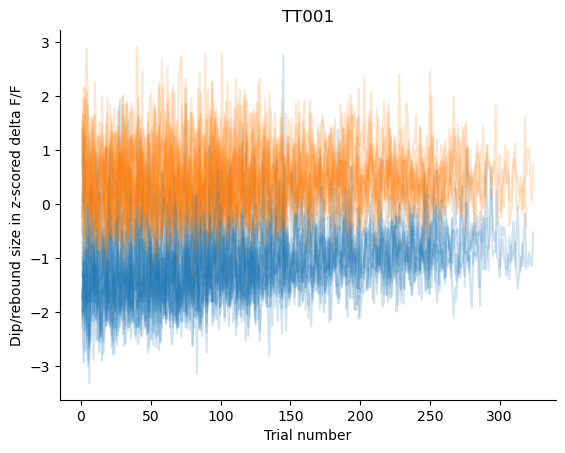

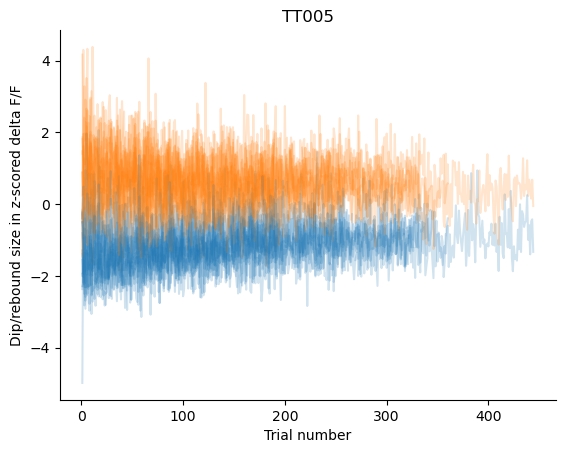

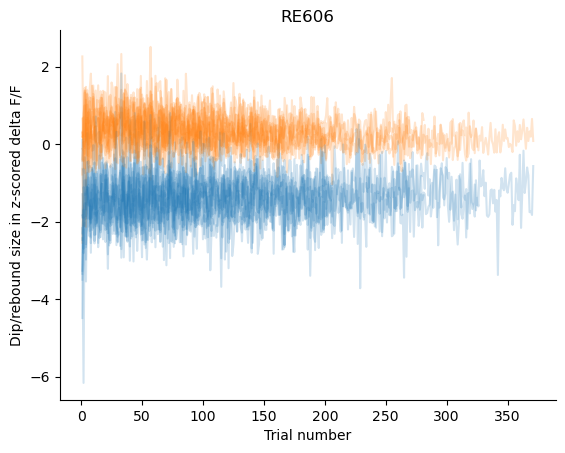

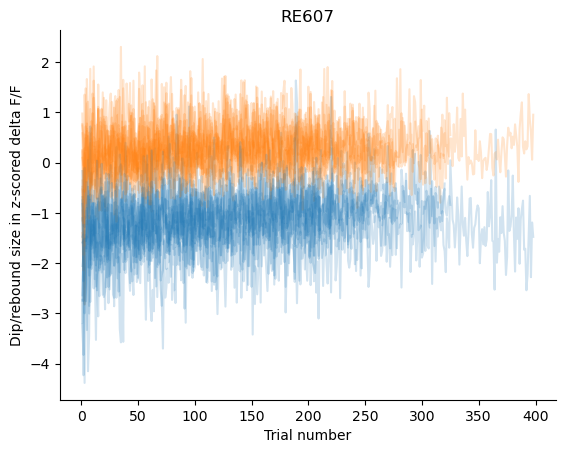

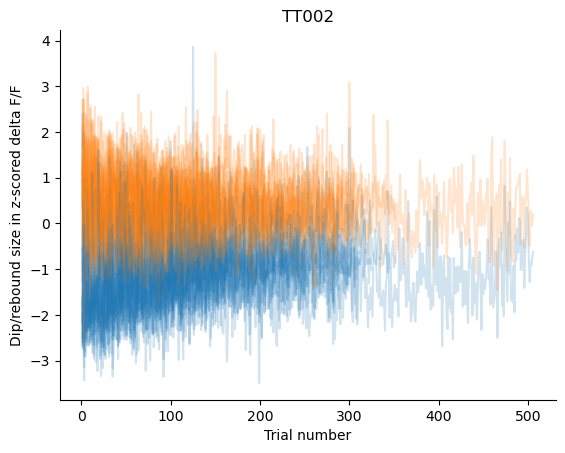

In [19]:
subject_ids_ = set(df_ACh_cue_onset_100['subject_id'])

for sbj in subject_ids_:

    fig, ax = plt.subplots()

    df_ACh_cue_onset_100['subject_id'] == sbj

    ax.set_title(sbj)

    ind = df_ACh_cue_onset_100.loc[df_ACh_cue_onset_100['subject_id'] == sbj].index

    for i in ind:
        
        ax.plot(df_ACh_cue_onset_100['df_trials'][i]['trial_nb'], 
                df_ACh_cue_onset_100['df_trials'][i]['dip'], color = '#1f77b4', alpha = 0.2)
        ax.plot(df_ACh_cue_onset_100['df_trials'][i]['trial_nb'],
                df_ACh_cue_onset_100['df_trials'][i]['rebound'], color='#ff7f0e', alpha = 0.2)
        
        ax.set_xlabel('Trial number')
        ax.set_ylabel('Dip/rebound size in z-scored delta F/F')


# DA

([<matplotlib.axis.XTick at 0x2a55f695a30>,
 [Text(0, 0, 'kms062'),
  Text(1, 0, 'kms064'),
  Text(2, 0, 'kms063'),
  Text(3, 0, 'kms058'),
  Text(4, 0, 'JC317L')])

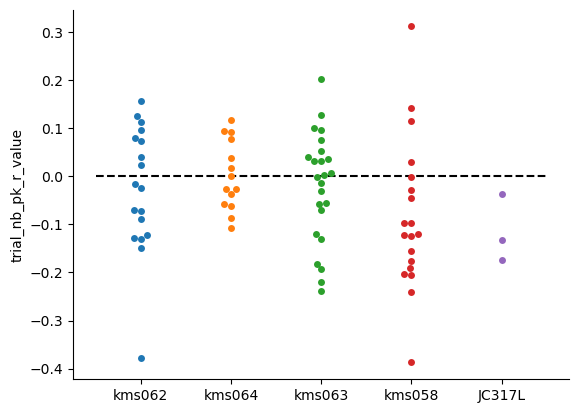

In [15]:
import seaborn as sns

fig, ax = plt.subplots()

subject_ids_ = set(df_DA_cue_onset_100['subject_id'])

for i, sbj in enumerate(subject_ids_):
    y = (df_DA_cue_onset_100['trial_nb_pk_r_value']
         [df_DA_cue_onset_100['subject_id'] == sbj])
    # y = np.mean(df_DA_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_DA_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)


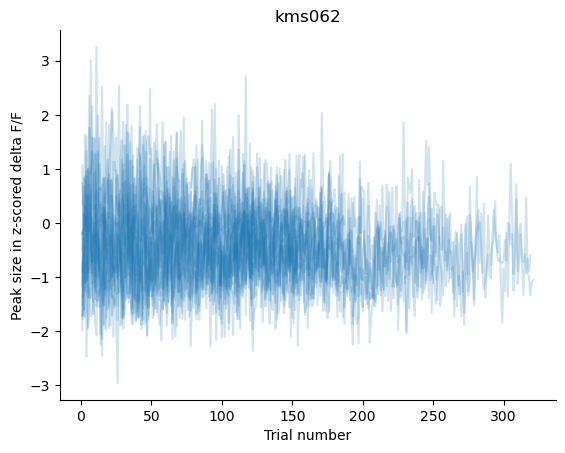

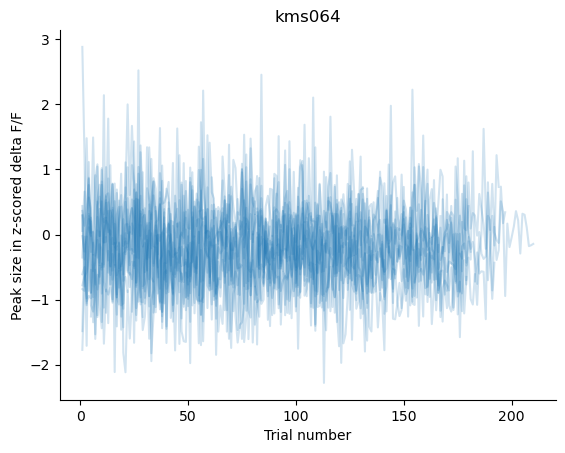

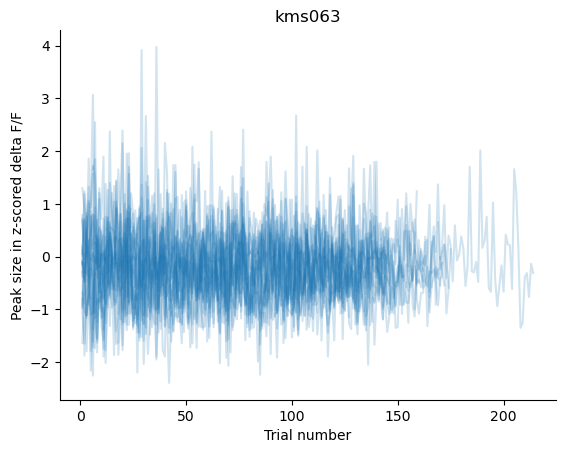

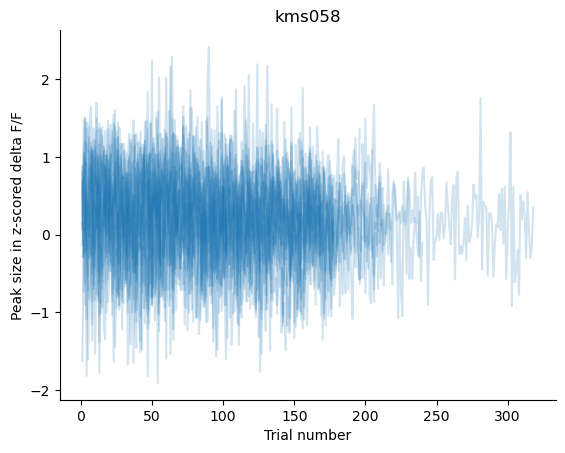

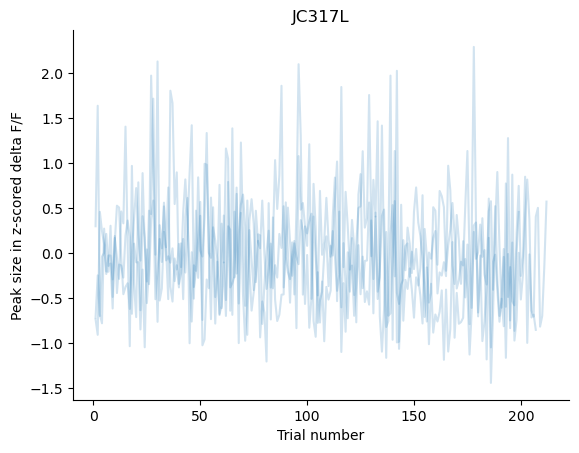

In [20]:
subject_ids_ = set(df_DA_cue_onset_100['subject_id'])

for sbj in subject_ids_:

    fig, ax = plt.subplots()

    df_DA_cue_onset_100['subject_id'] == sbj

    ax.set_title(sbj)

    ind = df_DA_cue_onset_100.loc[df_DA_cue_onset_100['subject_id'] == sbj].index

    for i in ind:
        
        ax.plot(df_DA_cue_onset_100['df_trials'][i]['trial_nb'], 
                df_DA_cue_onset_100['df_trials'][i]['peak'], color = '#1f77b4', alpha = 0.2)
        
        ax.set_xlabel('Trial number')
        ax.set_ylabel('Peak size in z-scored delta F/F')

In [ ]:
trial_nb_all = int(max(xr_session.trial_nb))


In [ ]:
# find_peaks
dip_values = []
reb_values = []

# Loop over trial numbers from 1 to trial_nb_all
for k in range(1, trial_nb_all+1):
    # Calculate the mean over the specified event_time interval for dip
    dip = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
        trial_nb=k, event_time=slice(75, 250))
    
    # Append the value to the list
    dip_values.append(dip.values.min())

    # Calculate the mean over the specified event_time interval for reb
    reb = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
        trial_nb=k, event_time=slice(200, 600)).mean(dim='event_time')
    # Append the value to the list
    reb_values.append(reb.values.max())

# Convert lists to pandas Series
dip_series = pd.Series(dip_values)
reb_series = pd.Series(reb_values)


In [ ]:

new_inex = range(1, trial_nb_all+1)
df_trials = pd.DataFrame({
    'trial_nb': list(range(1,trial_nb_all+1)),
    'dip': dip_series.reindex(new_inex),
    'rebound': reb_series.reindex(new_inex),
    'outcome': xr_session['trial_outcome'].values.T.flatten(),  # flatten is used to convert (175, 1) to (175,)
    })
df_trials

df_trials = df_trials.dropna(subset=['dip'])
df_trials = df_trials.dropna(subset=['rebound'])

In [ ]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(df_trials['trial_nb'], df_trials['dip'],'o')
# plt.plot(df_trials['trial_nb'], df_trials['rebound'],'o-')

plt.ylabel('Dip size')
plt.xlabel('Trial number')
plt.show()

In [ ]:
df_trials['trial_nb']


In [ ]:
from scipy.stats import pearsonr
from scipy.stats import linregress

corr, p_val = pearsonr(df_trials['trial_nb'], df_trials['dip'])

print(f'Pearsons correlation: {corr:.3f}, p = {p_val}')

slope, intercept, r_value, p_value, std_err = linregress(df_trials['trial_nb'], df_trials['dip'])


fig, ax1 = plt.subplots()

ax1.plot(df_trials['trial_nb'], df_trials['dip'],'o')
# plt.plot(df_trials['trial_nb'], df_trials['rebound'],'o-')

y_regress = df_trials['trial_nb'].values * slope + intercept

ax1.plot(df_trials['trial_nb'], y_regress)

plt.ylabel('Dip size')
plt.xlabel('Trial number')
plt.show()

In [ ]:
from matplotlib import pyplot as plt

corr, p_val = pearsonr(df_trials['trial_nb'], df_trials['rebound'])

print(f'Pearsons correlation: {corr:.3f}, p = {p_val}')

slope, intercept, r_value, p_value, std_err = linregress(
    df_trials['trial_nb'], df_trials['rebound'])


fig, ax1 = plt.subplots()

ax1.plot(df_trials['trial_nb'], df_trials['rebound'], 'o')

y_regress = df_trials['trial_nb'].values * slope + intercept

ax1.plot(df_trials['trial_nb'], y_regress)

plt.ylabel('Rebound size')
plt.xlabel('Trial number')
plt.show()


In [ ]:
from matplotlib import pyplot as plt

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams["legend.frameon"] = False
plt.rcParams['font.family'] = ['Arial']

fig, ax1 = plt.subplots()

ax1.plot( df_trials['outcome'], df_trials['rebound'], 'o', fillstyle='none')

plt.ylabel('rebound size')

plt.show()


In [ ]:
df_trials['dip'][df_trials['outcome'] == 'success']


In [ ]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(np.ones([np.count_nonzero(df_trials['outcome'] == 'success'),1]), df_trials['dip'][df_trials['outcome'] == 'success'],  'o', fillstyle='none')
ax1.boxplot(df_trials['dip'][df_trials['outcome'] == 'success'],  positions=[
            1.2], vert=True, patch_artist=False)

ax1.plot(np.ones([np.count_nonzero(df_trials['outcome'] == 'aborted'),1])*2, df_trials['dip'][df_trials['outcome'] == 'aborted'],  'o', fillstyle='none')
ax1.boxplot(df_trials['dip'][df_trials['outcome'] == 'aborted'],  positions=[
            2.2], vert=True, patch_artist=False)

ax1.plot(np.ones([np.count_nonzero(df_trials['outcome'] == 'no_reach'),1])*3, df_trials['dip'][df_trials['outcome'] == 'no_reach'],  'o', fillstyle='none')
ax1.boxplot(df_trials['dip'][df_trials['outcome'] == 'no_reach'],  positions=[
            3.2], vert=True, patch_artist=False)


ax1.set_xticklabels(['success','aborted','no_reach'])
plt.ylabel('Dip size')
plt.show()

In [ ]:
reach_dip


In [ ]:
fig, ax1 = plt.subplots()
# Get 'dip' values for 'reach' and 'no_reach' groups
reach_dip = df_trials['dip'][df_trials['outcome'].isin(
    ['success', 'aborted'])].dropna()
no_reach_dip = df_trials['dip'][df_trials['outcome'] == 'no_reach'].dropna()


ax1.plot(np.ones([reach_dip.shape[0], 1]),
         reach_dip,  'o', fillstyle='none')
ax1.boxplot(reach_dip,  positions=[
            1.2], vert=True, patch_artist=False)

ax1.plot(np.ones([no_reach_dip.shape[0], 1])*2,
         no_reach_dip,  'o', fillstyle='none')
ax1.boxplot(no_reach_dip,  positions=[
            2.2], vert=True, patch_artist=False)


ax1.set_xticklabels(['Reach',  'No reach'])
plt.ylabel('Dip size')
plt.show()


In [ ]:
from scipy.stats import mannwhitneyu

# Get 'dip' values for 'reach' and 'no_reach' groups
reach_dip = df_trials['dip'][df_trials['outcome'].isin(
    ['success', 'aborted'])].dropna()
no_reach_dip = df_trials['dip'][df_trials['outcome'] == 'no_reach'].dropna()

# Perform Mann-Whitney U test
u_val, p_val = mannwhitneyu(reach_dip, no_reach_dip, alternative='two-sided')

print('U-value:', u_val)
print('p-value:', p_val)


In [ ]:
import scipy.stats as stats

# Get dip values for each outcome category
success_dip = df_trials['dip'][df_trials['outcome'] == 'success'].dropna()
aborted_dip = df_trials['dip'][df_trials['outcome'] == 'aborted'].dropna()
no_reach_dip = df_trials['dip'][df_trials['outcome'] == 'no_reach'].dropna()

# Perform ANOVA
f_val, p_val = stats.f_oneway(success_dip, aborted_dip, no_reach_dip)

print('F-value:', f_val)
print('p-value:', p_val)


In [ ]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(np.ones([np.count_nonzero(df_trials['outcome'] == 'success'),1]), df_trials['rebound'][df_trials['outcome'] == 'success'],  'o', fillstyle='none')
ax1.boxplot(df_trials['rebound'][df_trials['outcome'] == 'success'],  positions=[
            1.2], vert=True, patch_artist=False)

ax1.plot(np.ones([np.count_nonzero(df_trials['outcome'] == 'aborted'),1])*2, df_trials['rebound'][df_trials['outcome'] == 'aborted'],  'o', fillstyle='none')
ax1.boxplot(df_trials['rebound'][df_trials['outcome'] == 'aborted'],  positions=[
            2.2], vert=True, patch_artist=False)

ax1.plot(np.ones([np.count_nonzero(df_trials['outcome'] == 'no_reach'),1])*3, df_trials['rebound'][df_trials['outcome'] == 'no_reach'],  'o', fillstyle='none')
ax1.boxplot(df_trials['rebound'][df_trials['outcome'] == 'no_reach'],  positions=[
            3.2], vert=True, patch_artist=False)


ax1.set_xticklabels(['success','aborted','no_reach'])
plt.ylabel('Rebound size')
plt.show()

In [ ]:
df_trials100 = df_trials.loc[0:99, :]


In [ ]:
from matplotlib import pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(np.ones([np.count_nonzero(df_trials100['outcome'] == 'success'), 1]),
         df_trials100['dip'][df_trials100['outcome'] == 'success'],  'o', fillstyle='none')
ax1.boxplot(df_trials100['dip'][df_trials100['outcome'] == 'success'],  positions=[
            1.2], vert=True, patch_artist=False)

ax1.plot(np.ones([np.count_nonzero(df_trials100['outcome'] == 'aborted'), 1])*2,
         df_trials100['dip'][df_trials100['outcome'] == 'aborted'],  'o', fillstyle='none')
ax1.boxplot(df_trials100['dip'][df_trials100['outcome'] == 'aborted'],  positions=[
            2.2], vert=True, patch_artist=False)

ax1.plot(np.ones([np.count_nonzero(df_trials100['outcome'] == 'no_reach'), 1])*3,
         df_trials100['dip'][df_trials100['outcome'] == 'no_reach'],  'o', fillstyle='none')
ax1.boxplot(df_trials100['dip'][df_trials100['outcome'] == 'no_reach'],  positions=[
            3.2], vert=True, patch_artist=False)


ax1.set_xticklabels(['success', 'aborted', 'no_reach'])
plt.ylabel('Dip size')
plt.show()


In [ ]:
fig, ax1 = plt.subplots()
# Get 'dip' values for 'reach' and 'no_reach' groups
reach_dip = df_trials100['dip'][df_trials100['outcome'].isin(
    ['success', 'aborted'])].dropna()
no_reach_dip = df_trials100['dip'][df_trials100['outcome'] == 'no_reach'].dropna()


ax1.plot(np.ones([reach_dip.shape[0], 1]),
         reach_dip,  'o', fillstyle='none')
ax1.boxplot(reach_dip,  positions=[
            1.2], vert=True, patch_artist=False)

ax1.plot(np.ones([no_reach_dip.shape[0], 1])*2,
         no_reach_dip,  'o', fillstyle='none')
ax1.boxplot(no_reach_dip,  positions=[
            2.2], vert=True, patch_artist=False)


ax1.set_xticklabels(['Reach',  'No reach'])
plt.ylabel('Dip size')
plt.show()